<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics-project/blob/main/base_code_with_dummy_init_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install STAN requirements

In [1]:
!pip install cmdstanpy

In [2]:
from cmdstanpy import install_cmdstan
install_cmdstan(compiler=True, progress=True)

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0


0.00B [00:00, ?B/s]

Download successful, file: /tmp/tmp5_37uhj5
Extracting distribution


  0%|          | 0/22079 [00:00<?, ?it/s]

Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


 (00:00) |            | Building CmdStan                     

DEBUG:cmdstanpy:cmd: make build -j1
cwd: None
DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [3]:
!pip install arviz

## Dummy init script

In [4]:
import json
import os
import shutil
import re

from typing import List

import numpy as np
import pandas as pd


def dump_multichain_inits(
        sample: pd.DataFrame,
        inits_directory: str,
        init_vars: List[str],
        num_chains: int,
) -> List[str]:
    """Simple script that assembles a set of approximate samples (e.g., from a variational inference run) into
    distinct initializations for each chain.
    You must provide:
    - sample (pd.DataFrame): the collection of approximate samples from the posterior;
    - inits_directory (str): the directory where to store the initializations, as per-chain json files;
    - init_vars (List[str]): the variables that **should** be initialized;
    - num_chains (int): the number of chains you are planning to run; the number of samples must be eactly divisible
        by this number!

    Returns: the list of paths to the jsons containing the initializations to each chain, that you should pass
        to the sample() algorithm
    """
    # regenerating the directory
    if os.path.isdir(os.path.join(inits_directory)):
        shutil.rmtree(os.path.join(inits_directory))
    os.makedirs(os.path.join(inits_directory), exist_ok=True)

    # dumping the initialization
    inits = []

    assert sample.shape[0] % num_chains == 0, "The number of samples should be exactly divisible by num_chains!"
    reps = sample.shape[0] // num_chains
    assert reps >= 0, "Need at least 1 sample per chain!"
    sample['assignment'] = np.repeat(range(num_chains), reps)
    for i in range(num_chains):
        chain_i_inits = {}
        for var in init_vars:
            var_samples = sample.loc[sample['assignment'] == i, :].filter(regex=rf'^{var}\[').mode().iloc[0, :]
            assert len(var_samples) > 0, f'No variables found with name "{var}"!'
            # these regular expressions are just to collect the columns corresponding to the different variables
            #   also, we do some rearranging to make sure that the stuff we save has the correct shape...
            vec_pttrn = rf'^{var}\[\d+]'
            mat_pttrn = rf'^{var}\[(\d+),\d+]'
            if all([re.match(vec_pttrn, ind) is not None for ind in var_samples.index]):
                # list variables, indexed by a single parenthesised index
                chain_i_inits[var] = var_samples.values.copy().tolist()
            elif all([re.match(mat_pttrn, ind) is not None for ind in var_samples.index]):
                # matrix variables, indexed by two indices separated by a comma (must be reshaped)
                shape_0 = max([int(re.match(mat_pttrn, ind).group(1)) for ind in var_samples.index])
                chain_i_inits[var] = var_samples.values.copy().reshape((shape_0, -1)).tolist()
            else:
                raise ValueError(f'Unexpected shape for variable {var}!')
        with open(os.path.join(inits_directory, f'chain_{i}_init.json'), 'w') as handle:
            json.dump(chain_i_inits, handle)
        inits.append(os.path.join(inits_directory, f'chain_{i}_init.json'))

    return inits

## Imports

In [5]:
import os
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt

## Model Definition and Input Variables

In [29]:
folder_name = "stan"
model_name = "model"
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

code = """
/* definition of the input data */
data {
    // dimensions
    int<lower = 1> N;   // number of datapoints
    int<lower = 2> M;   // number of experts
    int<lower = 1> P;   // number of features
    int<lower = 1> Q;   // number of embeddings
    int<lower = 1> T;   // number of test datapoints

    // training observations
    matrix[N, P] x;     // covariates
    matrix[N, Q] phi_x; // embeddings of covariates
    vector[N] y;        // outputs

    // test data
    matrix[T, P] v;     // test covariates
    matrix[T, Q] phi_v; // test embeddings of covariates
    vector[T] w;        // test outputs

    // prior hyperparameters
    matrix[M, P] theta_means;
    matrix<lower = 0>[M, P] theta_sigmas;
    vector[M] sigmas_log_means;
    vector[M] sigmas_log_sigmas;
    matrix[M, Q] alphas_coef_means;
    matrix<lower = 0>[M, Q] alphas_coef_sigmas;

    // competitive/collaborative behaviour
    vector[Q] betas_coef_means;
    vector<lower = 0>[Q] betas_coef_sigmas;
}

/* auxiliary variables */
transformed data {
    // since the softmax is invariant to scaling, we fix one of the entries to zero to avoid unidentifiability
    row_vector[Q] zeros = rep_row_vector(0, Q);
}

/* definition of model parameters */
parameters {
    // training variables
    matrix[M, P] thetas;
    vector<lower=0>[M] sigmas;

    // beta (top-level/behaviour gating)
    vector[Q] betas_coef;

    // alpha (mixture gating)
    matrix[M - 1, Q] alphas_raw_coef;
}

/* nonlinear parameter transformations and links */
transformed parameters {
    // means of the dirichlet components
    matrix[M, Q] alphas_coef = append_row(alphas_raw_coef, zeros);
    vector[M] sigmas_sq = square(sigmas+ 1e-6);
}

/* definition of model parameters */
parameters {
    // training variables
    matrix[M, P] thetas;
    vector<lower=0>[M] sigmas;

    // beta (top-level/behaviour gating)
    vector[Q] betas_coef;

    // alpha (mixture gating)
    matrix[M - 1, Q] alphas_raw_coef;
}

/* nonlinear parameter transformations and links */
transformed parameters {
    // means of the dirichlet components
    matrix[M, Q] alphas_coef = append_row(alphas_raw_coef, zeros);
    vector[M] sigmas_sq = square(sigmas);
}

/* definition of the model */
model {
    // priors - gatings
    for (i in 1:Q) {
        betas_coef[i] ~ double_exponential(betas_coef_means[i], betas_coef_sigmas[i]);
    }
    for (i in 1:M-1) {
        for (j in 1:Q) {
            alphas_raw_coef[i, j] ~ double_exponential(alphas_coef_means[i, j], alphas_coef_sigmas[i, j]);
        }
    }

    // priors - experts
    for (i in 1:M) {
        sigmas[i] ~ lognormal(sigmas_log_means[i], sigmas_log_sigmas[i]);
        for (j in 1:P) {
            thetas[i, j] ~ normal(theta_means[i, j], theta_sigmas[i, j]);
        }
    }
}

    // likelihood
    for (n in 1:N) {
        vector[M+1] lse_args;
        vector[M] alpha_scores = alphas_coef * phi_x[n]';
        vector[M] log_softmax_alphas = log_softmax(alpha_scores);
        vector[M] softmax_alphas = softmax(alpha_scores - max(alpha_scores));

        real beta_scores = phi_x[n] * betas_coef;
        real log_beta = beta_scores - log1p_exp(beta_scores);
        real log1m_beta = -log1p_exp(beta_scores);

        // competitive term in the likelihood
        for (m in 1:M) {
            lse_args[m] = log_beta + log_softmax_alphas[m] + normal_lpdf(y[n] | thetas[m] * x[n]', sigmas[m]);
        }

        // collaborative term in the likelihood
        real coll_log_loss = normal_lpdf(y[n] | softmax_alphas' * thetas * x[n]', sqrt(softmax_alphas' * sigmas_sq + 1e-6));
        lse_args[M+1] = log1m_beta + coll_log_loss;

        // combining the contributions
        target += log_sum_exp(lse_args);
    }
}

/* quantities we need to store in order to compute WAIC */
generated quantities {
    vector[T] y_new;
    vector[M] debug_sigmas = sigmas;

    for (t in 1:T) {
        vector[M+1] lse_args_new;
        vector[M] alpha_scores_new = alphas_coef * phi_v[t]';
        vector[M] log_softmax_alphas_new = log_softmax(alpha_scores_new);
        vector[M] softmax_alphas_new = softmax(alpha_scores_new - max(alpha_scores_new));

        real beta_scores_new = phi_v[t] * betas_coef;
        real log_beta_new = beta_scores_new - log1p_exp(beta_scores_new);
        real log1m_beta_new = -log1p_exp(beta_scores_new);

        for (m in 1:M) {
            lse_args_new[m] = log_beta_new + log_softmax_alphas_new[m] + normal_lpdf(w[t] | thetas[m] * v[t]', sigmas[m]);
        }

        real safe_sigma = sqrt(softmax_alphas_new' * (sigmas .* sigmas) + 1e-6);
        if (safe_sigma <= 0 || isnan(safe_sigma)) {
            safe_sigma = 1e-3;
        }
        y_new[t] = normal_rng(softmax_alphas_new' * thetas * v[t]', safe_sigma);
   }
}

"""

In [30]:
# Hyperparameters
alphas_coef_means = [[15.0, -50.0, 0.0], [-30.0, 50.0, 0.0], [0.0, 0.0, 0.0]]
alphas_coef_sigmas = [[1.0, 0.1, 0.01], [1.0, 0.1, 0.01], [1.0, 1.0, 1.0]]
betas_coef_means = [-1.6137318461999999, -1.2966869064000006, -0.9773183402999996]
betas_coef_sigmas = [0.5300025697274576, 0.10300716052089773, 0.11656114525858899]
sigmas_log_means = [-5.0, -3.0, -1.0]
sigmas_log_sigmas = [0.2, 0.2, 0.2]
theta_means = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
theta_sigmas = [[1.0, 0.01, 0.01], [1.0, 0.01, 0.01], [0.5, 2.0, 2.0]]

## Read CSV Data

In [31]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

df_train = pd.read_csv(train_data_file)
df_test = pd.read_csv(test_data_file)

In [32]:
df_test.head()

record  ones   x.times  x.times_quad  x.cos_times  x.sin_times   y.accel  \
0       3     1  0.062500      0.305556     0.555570     0.831470  0.000000   
1       6     1  0.114583      0.517747    -0.227076     0.973877 -0.020149   
2      11     1  0.152778      0.648834    -0.737277     0.675590 -0.020149   
3      10     1  0.152778      0.648834    -0.737277     0.675590 -0.009701   
4      13     1  0.173611      0.711591    -0.915311     0.402747 -0.020149   

   strata         v  
0     1.0  0.027612  
1     1.0  0.027612  
2     NaN       NaN  
3     1.0  0.027612  
4     1.0  0.027612

## Create STAN File

In [33]:
# Create folder to store .stan files
if not os.path.exists(f"./{folder_name}"):
    os.mkdir(f"./{folder_name}")
# Write model to file
stan_file = f"./{folder_name}/{model_name}.stan"
with open(stan_file, "w") as f:
    print(code, file=f)

## Compile and run Model


In [34]:
# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

ValueError: Failed to get source info for Stan model '/content/stan/model.stan'. Console:
Syntax error in '/content/stan/model.stan', line 61, column 0 to column 10, parsing error:
   -------------------------------------------------
    59:  
    60:  /* definition of model parameters */
    61:  parameters {
         ^
    62:      // training variables
    63:      matrix[M, P] thetas;
   -------------------------------------------------

"model {" or "generated quantities {" expected after end of transformed parameters block.


In [21]:
# here we define the sam variables defined in DATA section of .stan file
data = {
    # dimensions
    "N": 75,
    "M": 3,
    "P": 3,
    "Q": 3,
    "T": 58,
    # training observations
    "x": df_train[['ones','x.cos_times', 'x.sin_times']],
    "phi_x": df_train[['ones','x.times','x.times_quad']],
    # TODO: ask what embedding
    "y": df_train['y.accel'].to_numpy(),
    # test data
    "v": df_test[['ones','x.cos_times', 'x.sin_times']],
    "phi_v": df_test[['ones','x.times','x.times_quad']],
    "w": df_test['y.accel'].to_numpy(),
    # prior hyperparameters
    "theta_means": theta_means,
    "theta_sigmas": theta_sigmas,
    "sigmas_log_means": sigmas_log_means,
    "sigmas_log_sigmas": sigmas_log_sigmas,
    # competitive/collaborative behaviour
    "alphas_coef_means": alphas_coef_means,
    "alphas_coef_sigmas": alphas_coef_sigmas,
    "betas_coef_means": betas_coef_means,
    "betas_coef_sigmas": betas_coef_sigmas,

}

In [22]:
# using variational to generate samples to use as input to dummy init
vi = stan_model.variational(data=data, draws=4000)

vi_df = pd.DataFrame(vi.variational_sample)
vi_df.columns = vi.column_names

var_names = ["thetas", "sigmas", "betas_coef", "alphas_raw_coef","y_new"]

# run dummy init
inits = dump_multichain_inits(vi_df, "./initialization", var_names, 4)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0mhmfm0r/1jyadyee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/model', 'random', 'seed=17871', 'data', 'file=/tmp/tmp0mhmfm0r/1jyadyee.json', 'output', 'file=/tmp/tmp0mhmfm0r/model9howmgxk/model-20250211175823.csv', 'method=variational', 'adapt', 'engaged=1', 'output_samples=4000']
17:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RuntimeError: The algorithm may not have converged.
If you would like to inspect the output, re-call with require_converged=False

In [14]:
print(vi_df.columns)


Index(['lp__', 'log_p__', 'log_g__', 'thetas[1,1]', 'thetas[2,1]',
       'thetas[3,1]', 'thetas[1,2]', 'thetas[2,2]', 'thetas[3,2]',
       'thetas[1,3]', 'thetas[2,3]', 'thetas[3,3]', 'sigmas[1]', 'sigmas[2]',
       'sigmas[3]', 'betas_coef[1]', 'betas_coef[2]', 'betas_coef[3]',
       'alphas_raw_coef[1,1]', 'alphas_raw_coef[2,1]', 'alphas_raw_coef[1,2]',
       'alphas_raw_coef[2,2]', 'alphas_raw_coef[1,3]', 'alphas_raw_coef[2,3]',
       'alphas_coef[1,1]', 'alphas_coef[2,1]', 'alphas_coef[3,1]',
       'alphas_coef[1,2]', 'alphas_coef[2,2]', 'alphas_coef[3,2]',
       'alphas_coef[1,3]', 'alphas_coef[2,3]', 'alphas_coef[3,3]',
       'sigmas_sq[1]', 'sigmas_sq[2]', 'sigmas_sq[3]', 'y_new[1]', 'y_new[2]',
       'y_new[3]', 'y_new[4]', 'y_new[5]', 'y_new[6]', 'y_new[7]', 'y_new[8]',
       'y_new[9]', 'y_new[10]', 'y_new[11]', 'y_new[12]', 'y_new[13]',
       'y_new[14]', 'y_new[15]', 'y_new[16]', 'y_new[17]', 'y_new[18]',
       'y_new[19]', 'y_new[20]', 'y_new[21]', 'y_new[22]'

In [ ]:
print(var_names);

['thetas', 'sigmas', 'betas_coef', 'alphas_raw_coef', 'alphas_coef', 'sigmas_sq']


In [15]:
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample
stan_fit = stan_model.sample(data=data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000,
                             adapt_delta=0.90, max_treedepth=20, inits=inits)

DEBUG:cmdstanpy:cmd: /content/stan/model info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0mhmfm0r/h98rncpb.json
17:37:15 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/model', 'id=1', 'random', 'seed=51973', 'data', 'file=/tmp/tmp0mhmfm0r/h98rncpb.json', 'init=/tmp/tmp0mhmfm0r/_g8ke3pc_1.json', 'output', 'file=/tmp/tmp0mhmfm0r/modeleg9y16vg/model-20250211173715_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=20', 'adapt', 'engaged=1', 'delta=0.9']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/model', 'id=2', 'random', 'seed=51973', 'data', 'file=/tmp/tmp0mhmfm0r/h98rncpb.json', 'init=/tmp/tmp0mhmfm0r/_g8ke3pc_2.json', 'output', 'file=/tmp/tmp0mhmfm0r/modeleg9y16vg/model-20250211173715_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=20', 'adapt', 'engaged=1', 'delta=0.9']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdsta

17:47:56 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/model', 'id=1', 'random', 'seed=51973', 'data', 'file=/tmp/tmp0mhmfm0r/h98rncpb.json', 'init=/tmp/tmp0mhmfm0r/_g8ke3pc_1.json', 'output', 'file=/tmp/tmp0mhmfm0r/modeleg9y16vg/model-20250211173715_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=20', 'adapt', 'engaged=1', 'delta=0.9']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp0mhmfm0r/modeleg9y16vg/model-20250211173715_1.csv
 console_msgs (if any):
	/tmp/tmp0mhmfm0r/modeleg9y16vg/model-20250211173715_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defau

## Results Evaluation

In [16]:
cmdstanpy_data = az.from_cmdstanpy(stan_fit)


In [ ]:
az.summary(stan_fit, var_names=["debug_sigmas"])

#### Results Plotting

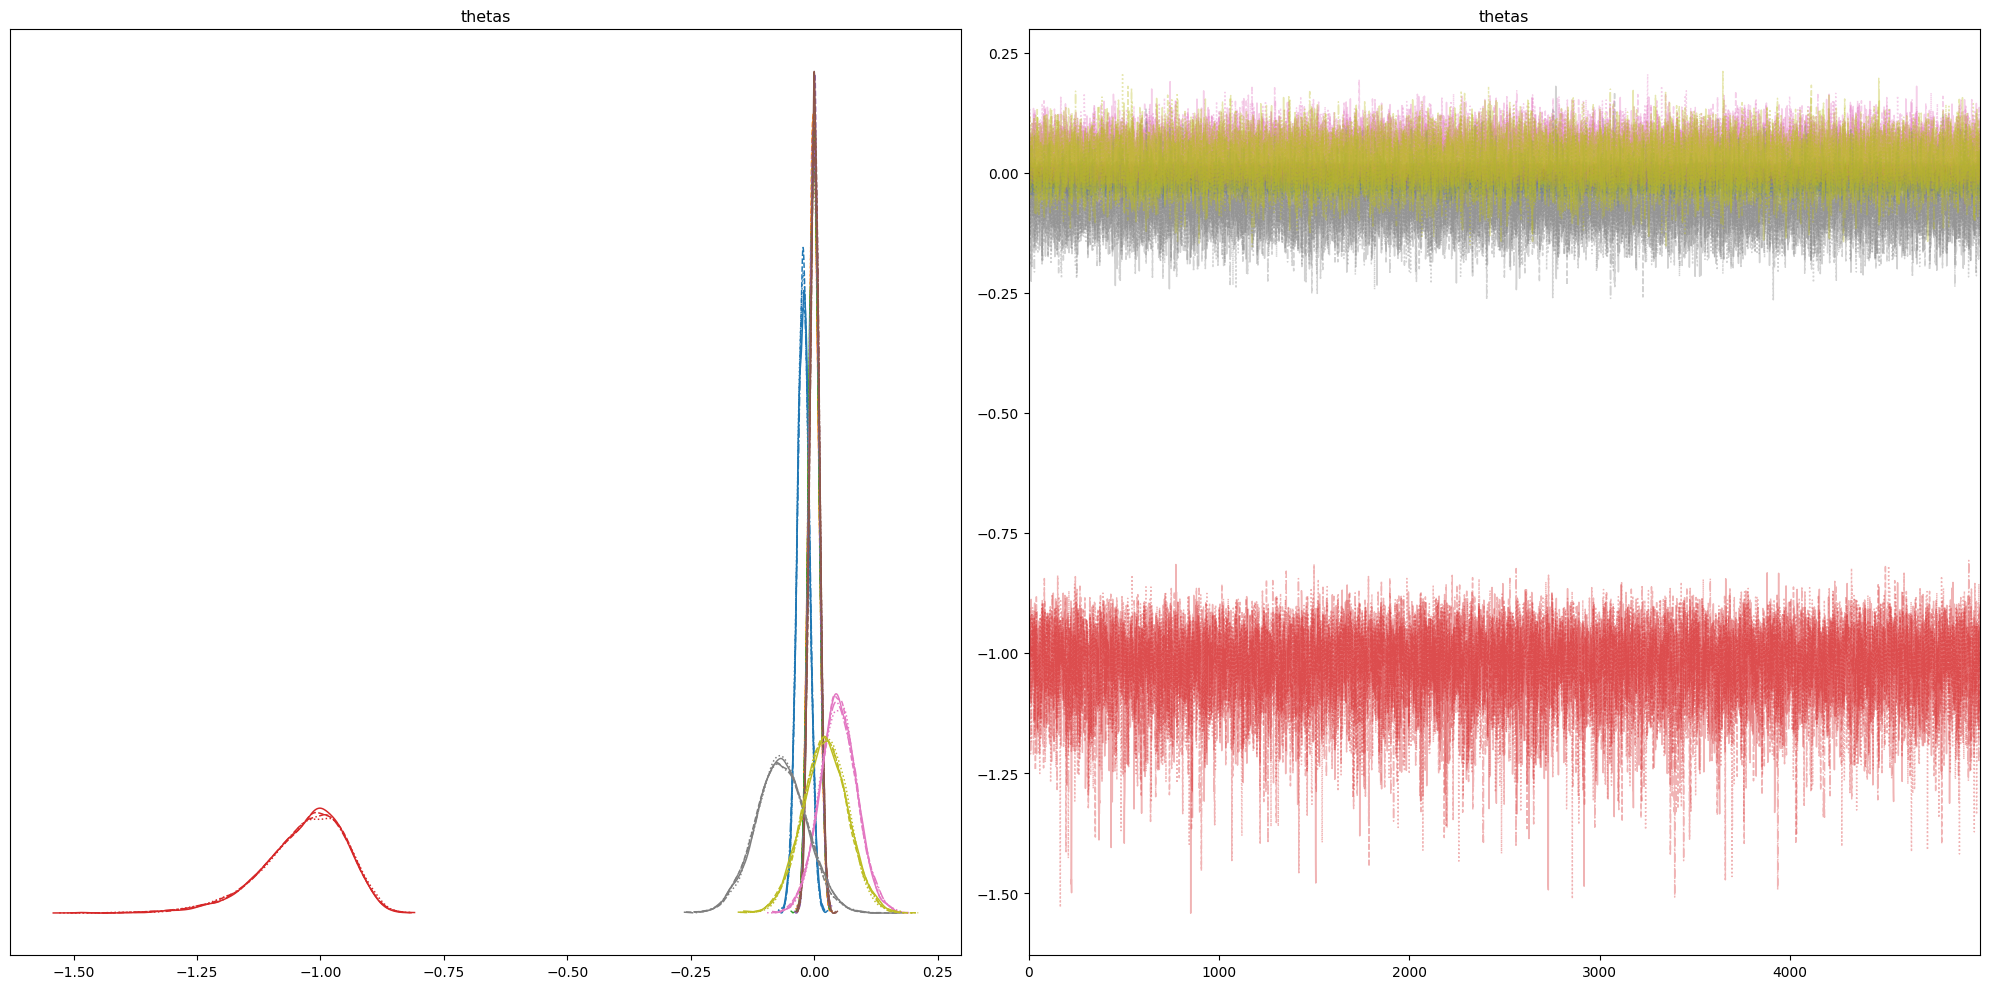

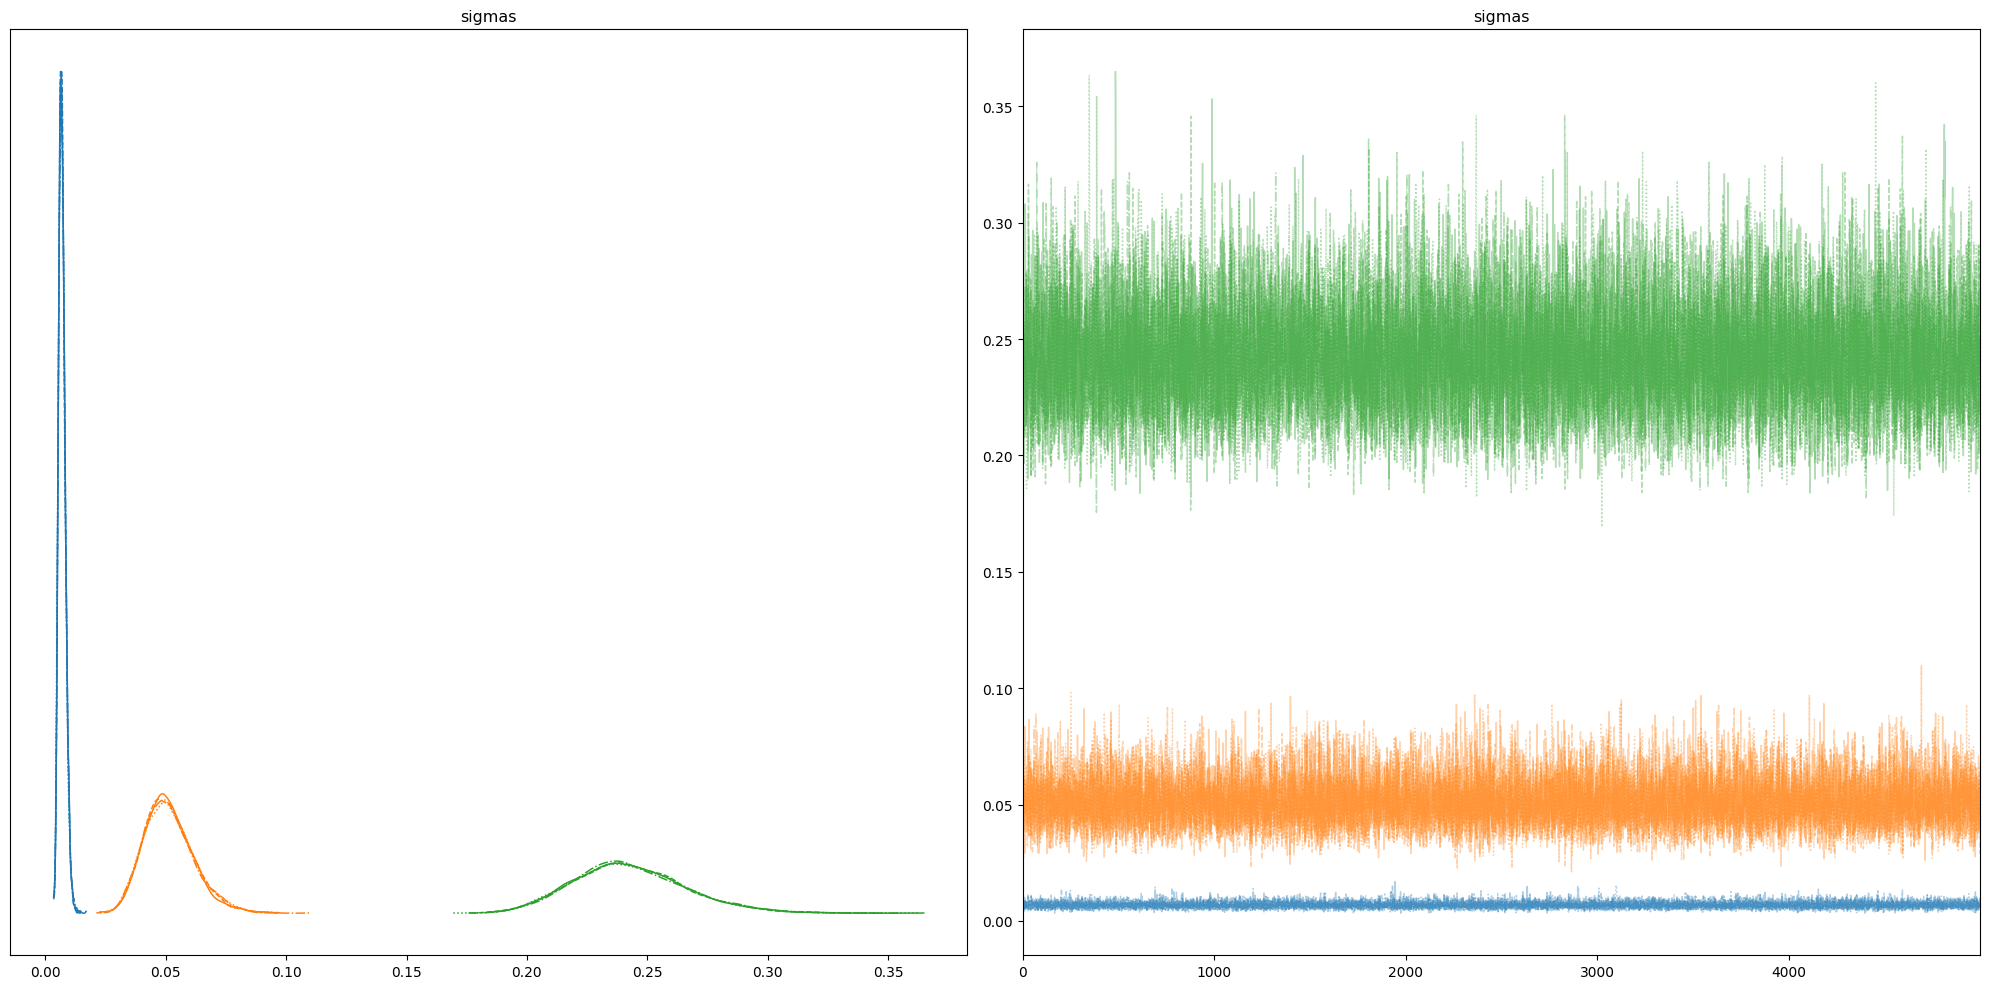

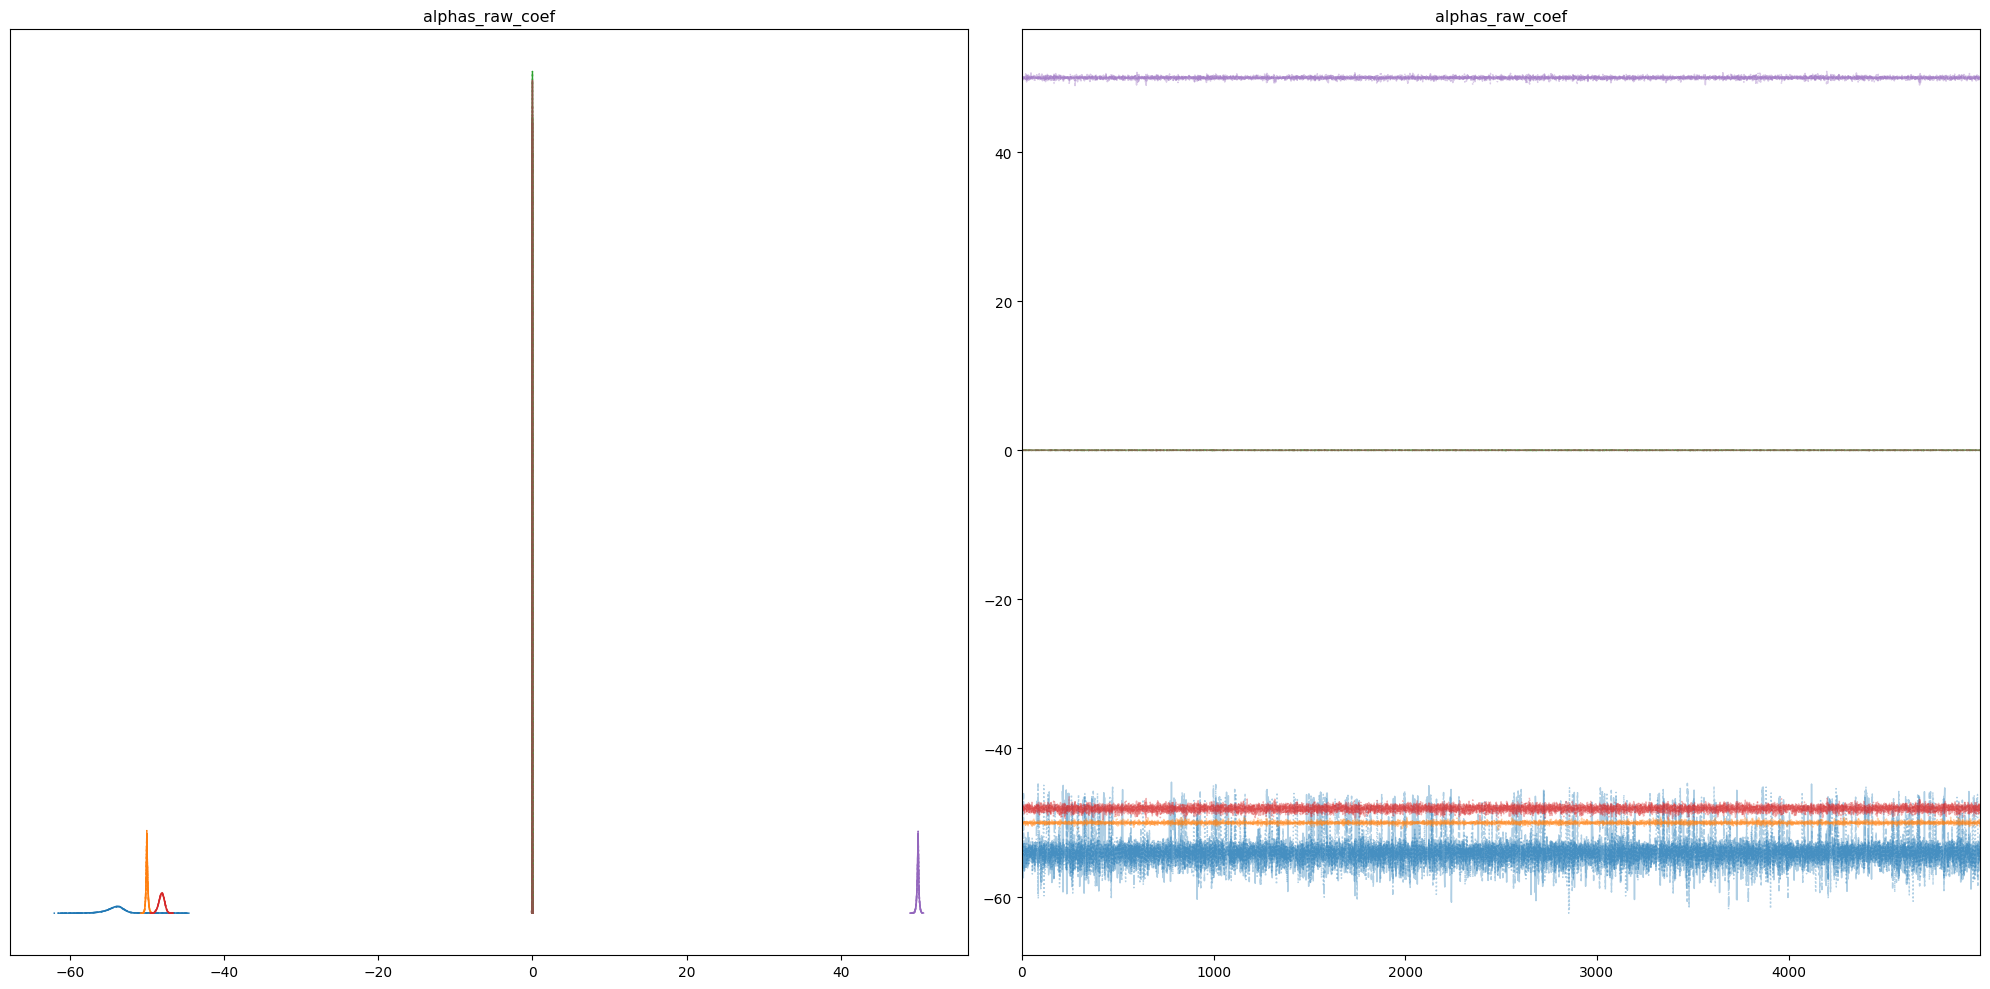

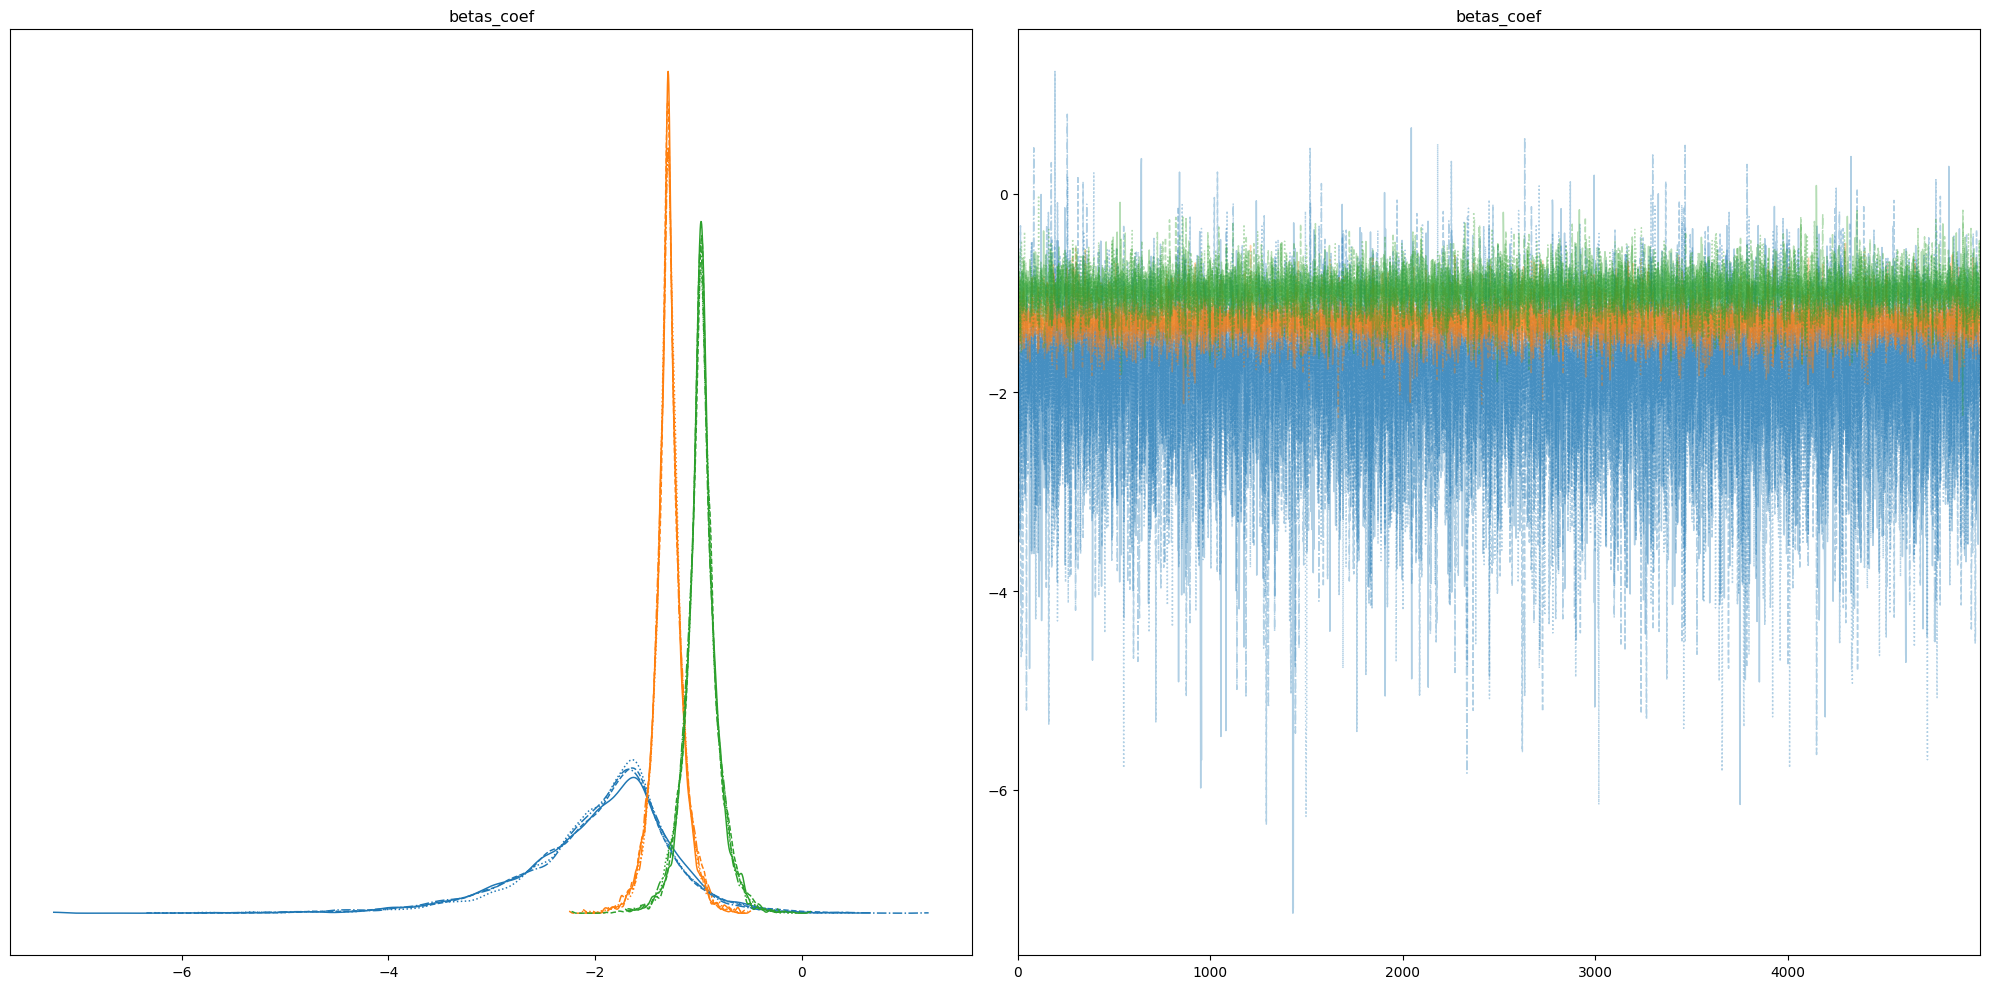

In [17]:
groups = ["thetas", "sigmas", "alphas_raw_coef", "betas_coef"]

for group in groups:
    az.plot_trace(
        cmdstanpy_data,           # ArviZ InferenceData object
        var_names=[group],      # Select `thetas` for plotting
        compact=True,
        figsize=(20,10)             # Combine dimensions into a single plot

    )
    plt.tight_layout()
    plt.show()

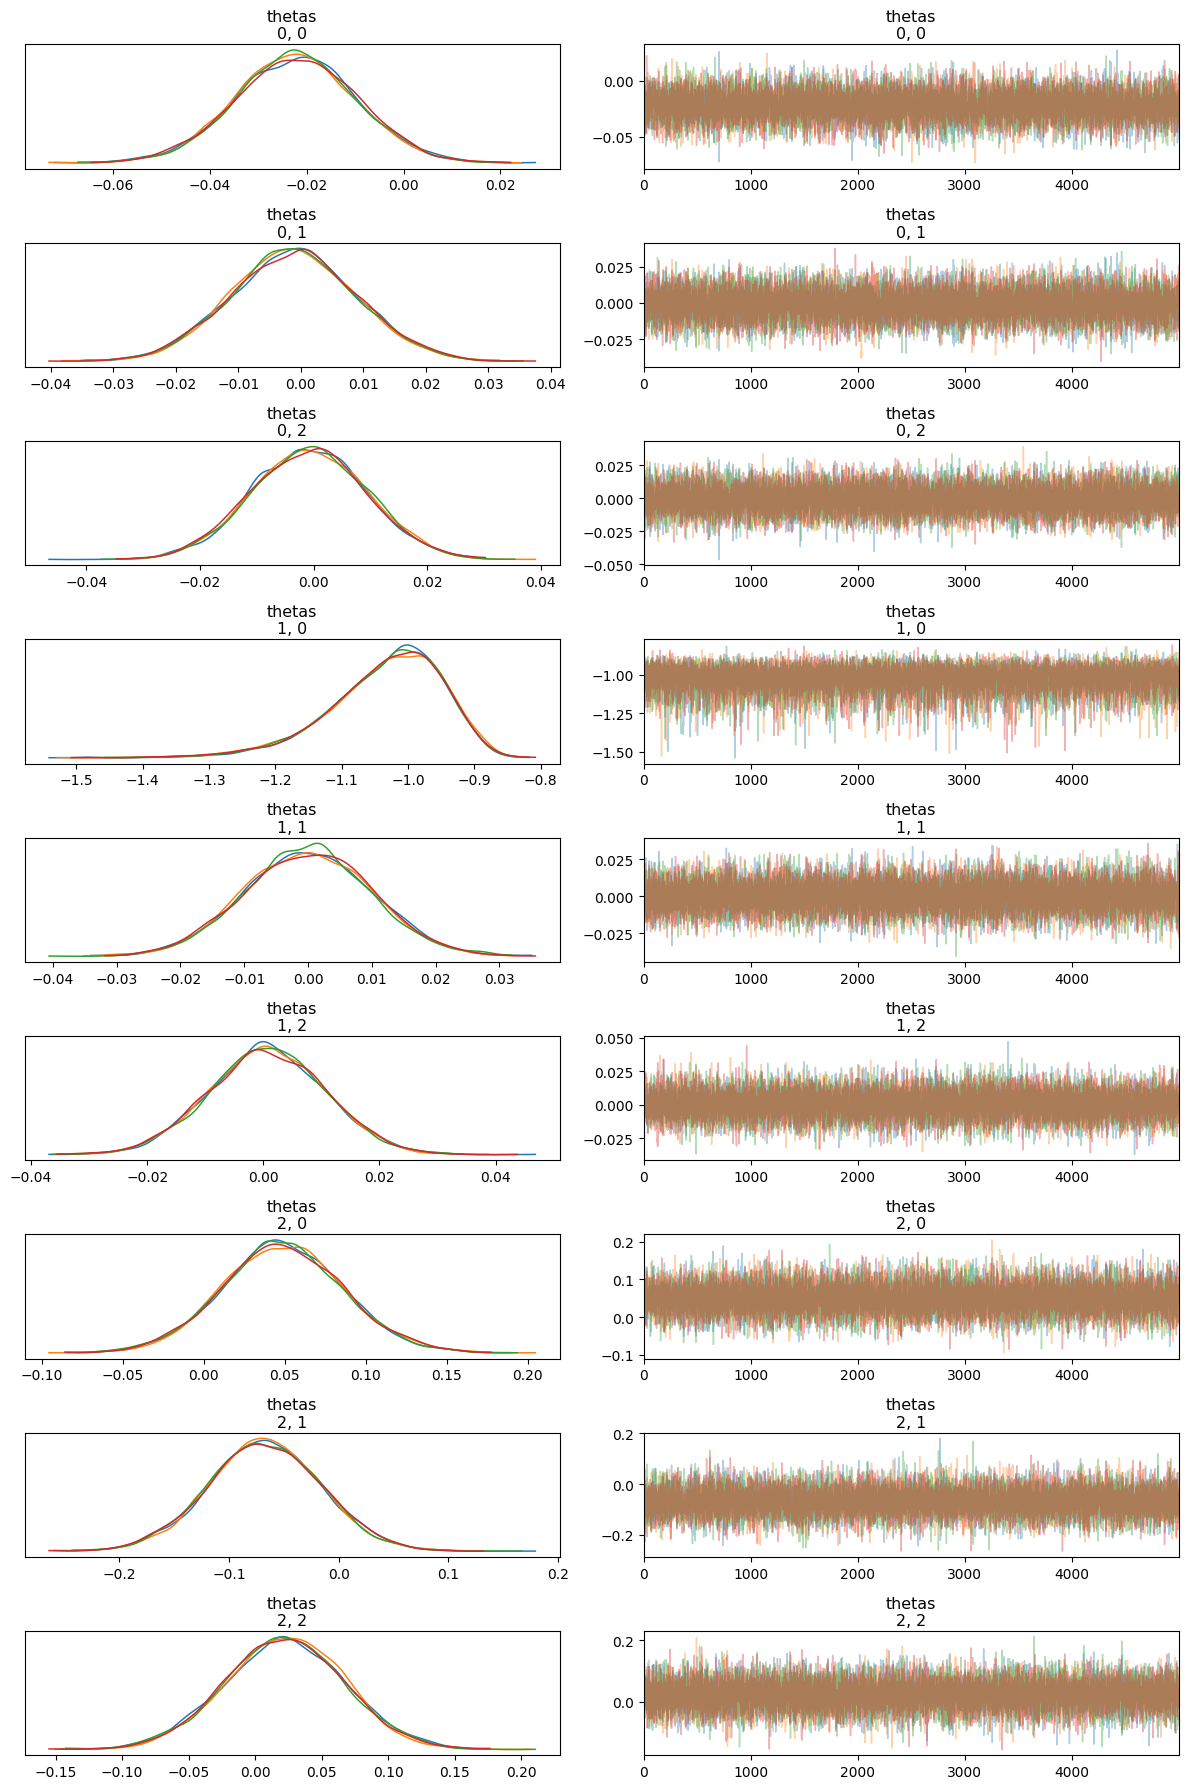

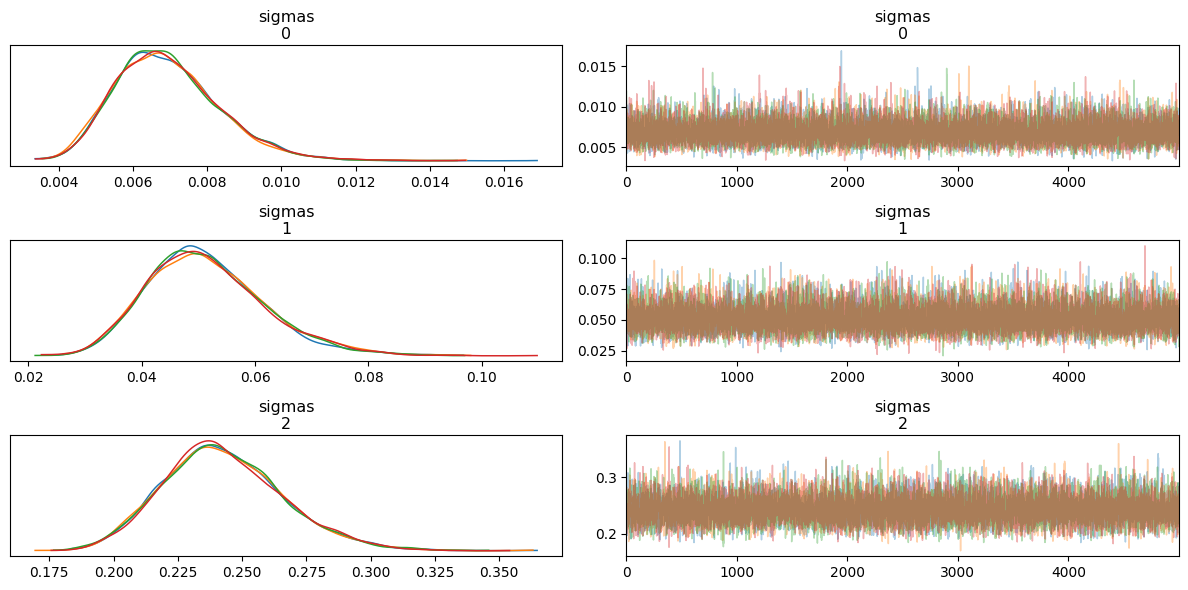

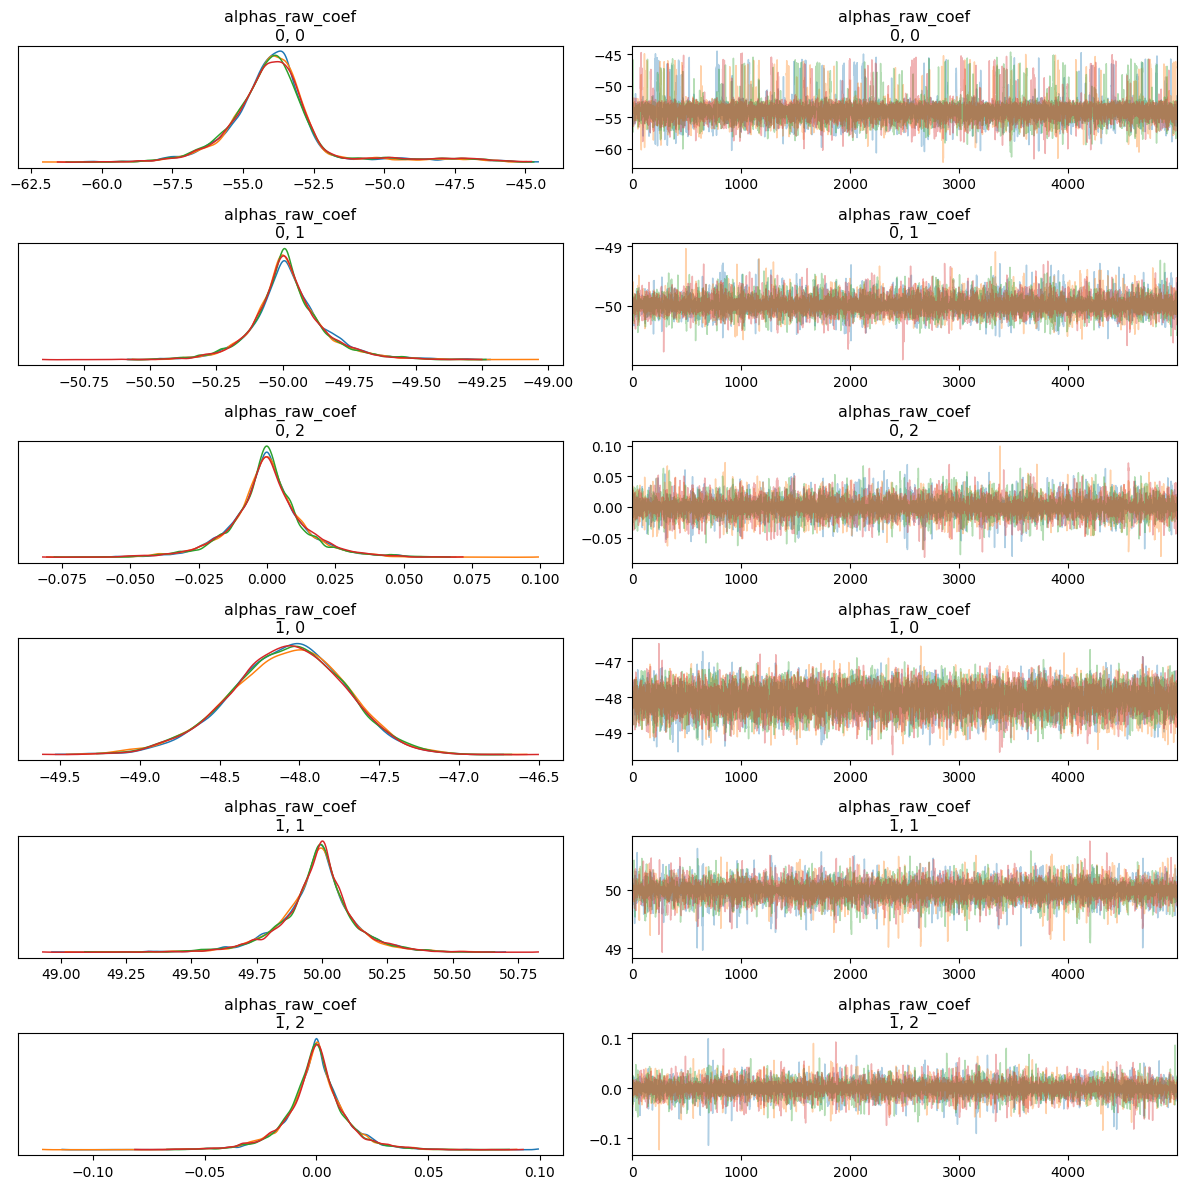

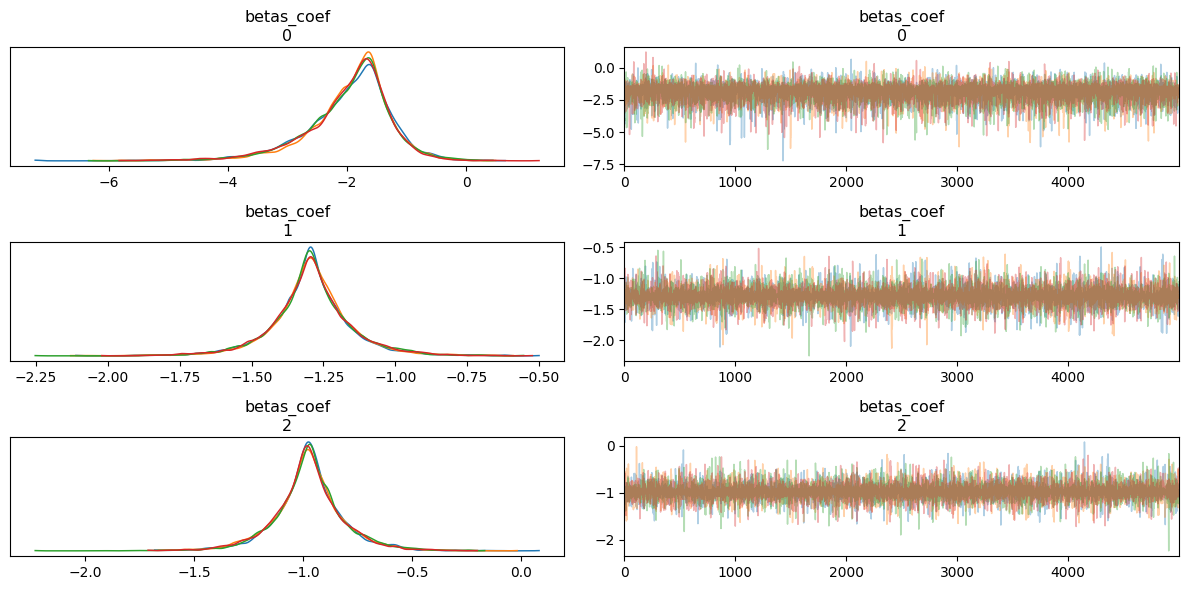

In [18]:
groups = ["thetas", "sigmas", "alphas_raw_coef", "betas_coef"]

for group in groups:
    az.plot_trace(
        cmdstanpy_data,           # ArviZ InferenceData object
        var_names=[group],      # Select `thetas` for plotting
        compact=False,
        #figsize=(20,10)             # Combine dimensions into a single plot

    )
    plt.tight_layout()
    plt.show()

#### Fit Evaluation

In [19]:
rhat_data = az.rhat(cmdstanpy_data)
rhat_max={}
for var_name in rhat_data.data_vars:
  rhat_val= rhat_data[var_name].max()
  rhat_max[var_name]=rhat_val
  print(f"{var_name}: {float(rhat_data[var_name].max())}")
  if rhat_data[var_name].max() >= 1.05:
      print(f"Convergence issue with {rhat_data[var_name]} ")

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


alphas_coef: 1.0005746148611472
alphas_raw_coef: 1.0005746148611472
betas_coef: 1.0013285429547252
sigmas: 1.0002415808843146
sigmas_sq: 1.000225903273461
thetas: 1.000735092066696
y_new: 1.0003336662218518


Maximum absolute error: 0.5213
Sum of squared errors: 2.5336


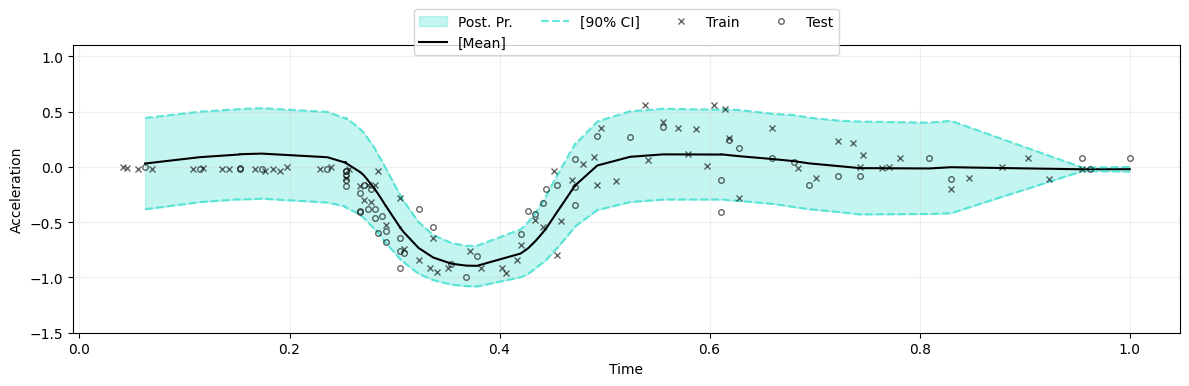

In [20]:
y_pred_samples = stan_fit.stan_variable('y_new')  # Shape: (n_samples, T)

y_pred_mean = np.mean(y_pred_samples, axis=0)
y_pred_median = np.median(y_pred_samples, axis=0)
y_pred_std = np.std(y_pred_samples, axis=0)
y_pred_lower = np.percentile(y_pred_samples, 5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 95, axis=0)

predictions_df = pd.DataFrame({
    'y_pred_mean': y_pred_mean,
    'y_pred_median': y_pred_median,
    'y_pred_std': y_pred_std,
    'y_pred_lower': y_pred_lower,
    'y_pred_upper': y_pred_upper,
    'y_true': df_test['y.accel'].to_numpy(),
})

# Calculate error metrics
max_error = np.linalg.norm(y_pred_mean - df_test['y.accel'].to_numpy(), ord=np.inf)
mse = np.sum((y_pred_mean - df_test['y.accel'].to_numpy())**2)

print(f"Maximum absolute error: {max_error:.4f}")
print(f"Sum of squared errors: {mse:.4f}")

# Create visualization
T = 58
# Combine training and test data in chronological order
full_times = np.concatenate([df_train['x.times'], df_test['x.times']])
full_data = np.concatenate([df_train['y.accel'], df_test['y.accel']])

# Create figure with white background
plt.figure(figsize=(12, 4))

# Set background grid
plt.grid(True, color='#cccccc', alpha=0.3, linestyle='-')

# Plot posterior predictive distribution for test period only
plt.fill_between(df_test['x.times'], y_pred_lower, y_pred_upper,
                color='turquoise', alpha=0.3,
                label='Post. Pr.')

# Plot mean prediction for test period
plt.plot(df_test['x.times'], y_pred_mean,
         color='black', linestyle='-',
         label='[Mean]', linewidth=1.5)

# Plot confidence intervals for test period
plt.plot(df_test['x.times'], y_pred_lower,
         color='turquoise', linestyle='--',
         label='[90% CI]', alpha=0.8)
plt.plot(df_test['x.times'], y_pred_upper,
         color='turquoise', linestyle='--',
         alpha=0.8)

# Plot training data
plt.plot(df_train['x.times'], df_train['y.accel'],
         'kx', label='Train', alpha=0.6, markersize=4)

# Plot test data
plt.plot(df_test['x.times'], df_test['y.accel'],
         'ko', markerfacecolor='none',
         label='Test', alpha=0.6, markersize=4)

# Customize axes
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.ylim(-1.5, 1.1)

# Set background color to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Create legend with two rows
plt.legend(ncol=4, loc='upper center',
          bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.show()

### Results Saving

In [ ]:
az.to_netcdf(cmdstanpy_data, "Base Results With Dummy Init")

'Base Results With Dummy Init'